In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

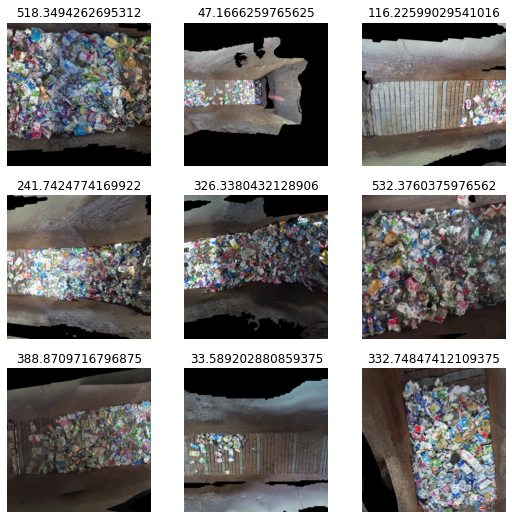

In [15]:
dls.show_batch()

In [15]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50Masav2')
]

In [16]:
from fastai.metrics import mae,rmse,mse

In [17]:
learn = Learner(dls, timm.create_model('resnetrs50',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,time
0,108565.046875,120109.539062,278.008484,00:09


Better model found at epoch 0 with valid_loss value: 120109.5390625.


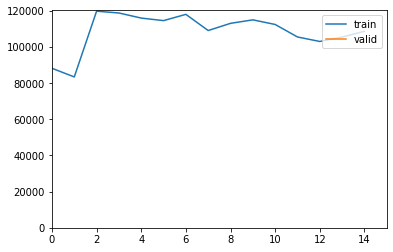

epoch,train_loss,valid_loss,mae,time
0,105412.914062,115191.984375,273.973846,00:06
1,102068.476562,84358.695312,239.591034,00:06
2,99060.335938,91365.953125,248.775711,00:06
3,95228.351562,90899.578125,248.021393,00:06
4,92470.046875,88882.554688,245.298416,00:06
5,90002.195312,76393.195312,228.668549,00:06
6,87422.320312,83093.007812,238.744843,00:06
7,84688.984375,78679.070312,233.292984,00:06
8,82499.015625,75847.265625,229.697266,00:06
9,80630.835938,72473.984375,225.209671,00:06


Better model found at epoch 0 with valid_loss value: 115191.984375.


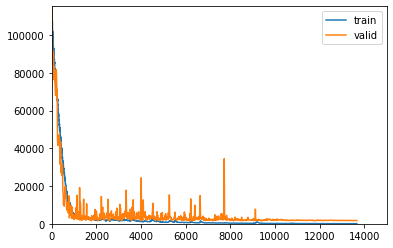

Better model found at epoch 1 with valid_loss value: 84358.6953125.
Better model found at epoch 5 with valid_loss value: 76393.1953125.
Better model found at epoch 8 with valid_loss value: 75847.265625.
Better model found at epoch 9 with valid_loss value: 72473.984375.
Better model found at epoch 10 with valid_loss value: 68178.53125.
Better model found at epoch 11 with valid_loss value: 68039.1171875.
Better model found at epoch 14 with valid_loss value: 66515.8828125.
Better model found at epoch 16 with valid_loss value: 44310.25.
Better model found at epoch 17 with valid_loss value: 41518.45703125.
Better model found at epoch 23 with valid_loss value: 34184.30859375.
Better model found at epoch 24 with valid_loss value: 31544.927734375.
Better model found at epoch 27 with valid_loss value: 27002.564453125.
Better model found at epoch 29 with valid_loss value: 25754.037109375.
Better model found at epoch 32 with valid_loss value: 16997.31640625.
Better model found at epoch 33 with va

KeyboardInterrupt: 

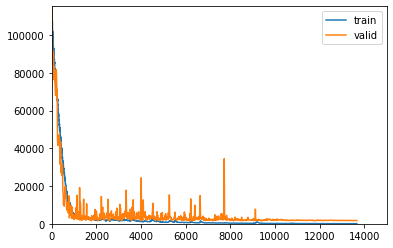

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [18]:
learn.load('resnetrs50Masav2')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [19]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [20]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [21]:
dlstest = dbtest.dataloaders(path,bs=16)

In [22]:
learn.dls=dlstest

In [23]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 35.41111755371094.


(#4) [3605.03271484375,35.41111755371094,60.04192352294922,3605.03271484375]

In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
preds,gt = learn.tta()

In [27]:
mean_absolute_error(gt,preds)

33.843727